# Geospatial research


In [ ]:
%pip install geopandas
%pip install geopy
%pip install matplotlib

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Sample events dataframe (flatten your JSON into pandas DataFrame)
data = {
    'id': [1, 2],
    'title': ["Padua Food & Drink Event #1", "San Donà di Piave Arts & Crafts Event #2"],
    'latitude': [45.4077172, 45.6294811],
    'longitude': [11.8734455, 12.5641057],
    # add other fields as needed
}

df = pd.DataFrame(data)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# Suppose you have a route as a LineString between Vicenza and Padua
route_coords = [(11.546699, 45.545932), (11.8734455, 45.4077172)]  # (lon, lat) tuples
route_line = LineString(route_coords)
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326")

# Reproject to metric CRS for buffering (meters)
gdf_m = gdf.to_crs(epsg=3857)
route_m = route_gdf.to_crs(epsg=3857)

# Create 1 km buffer around route
buffer = route_m.buffer(1000).iloc[0]

# Filter events within buffer polygon
events_in_buffer = gdf_m[gdf_m.geometry.within(buffer)]

# Convert filtered events back to lat/lon CRS for display
events_in_buffer_wgs = events_in_buffer.to_crs(epsg=4326)

print(events_in_buffer_wgs[['id', 'title', 'geometry']])


#### Quando ho estratto la lista di eventi, posso chiedere alla AI di darmi una lista e "condirmi" l'output con LLM

In [ ]:
import matplotlib.pyplot as plt

# Plot the route and the buffer
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (converted back to WGS84 for plotting with events)
route_gdf.to_crs(epsg=4326).plot(ax=ax, color='red', linewidth=2, label='Route')

# Plot the buffer (converted back to WGS84 for plotting with events)
buffer_wgs = gpd.GeoSeries([buffer], crs=3857).to_crs(epsg=4326)
buffer_wgs.plot(ax=ax, color='blue', alpha=0.3, label='1km Buffer')

# Plot the events
gdf.to_crs(epsg=4326).plot(ax=ax, color='green', marker='o', markersize=5, label='All Events')

# Plot events within the buffer
events_in_buffer_wgs.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events in Buffer')


ax.set_title("Route, Buffer, and Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

### Query verso qdrant di una route

In [12]:
import numpy as np
from shapely.geometry import LineString
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance

load_dotenv(dotenv_path="../superlinked/.env")

QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# 1. Define your route (lon, lat)
#route_coords = [(11.546699, 45.545932), (11.8834455, 45.4077172)]
route_coords = [
    (11.546698, 45.545932),     # Vicenza
    (11.6603917, 45.2254915),   # Este
    (11.8734458, 45.4077173),   # Padua
    (12.84052, 45.78071)        # Portogruaro
]



route_line = LineString(route_coords)

# 2. Buffer the route by 1km (1000 meters)
# Convert to a projected CRS for accurate buffering
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326").to_crs(epsg=3857)
buffer_poly = route_gdf.buffer(1000).to_crs(epsg=4326).iloc[0]  # back to WGS84

# 3. Get polygon coordinates for Qdrant (as [lon, lat] lists)
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()

# 4. Convert polygon coords to [{"lon": lon, "lat": lat}, ...] format for Qdrant
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]
# 5. Connect to Qdrant

# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd

# Prepare a list of dictionaries from the query results
# data = []
# for point in results.points:
#     data.append({
#         "title": point.payload.get("title"),
#         "description": point.payload.get("description"),
#         "latitude": point.payload.get("location", {}).get("lat"),
#         "longitude": point.payload.get("location", {}).get("lon")
#     })

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Show the results
# df

print(f"polygon con buffer",polygon_coords_qdrant)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



polygon con buffer [{'lon': 11.664791273307147, 'lat': 45.239221504665664}, {'lon': 11.866506739789068, 'lat': 45.41172236036489}, {'lon': 11.867077489776275, 'lat': 45.41216517962698}, {'lon': 11.867705347908895, 'lat': 45.41256811069976}, {'lon': 11.868384683837238, 'lat': 45.412927541168045}, {'lon': 11.869109405581856, 'lat': 45.413240248679564}, {'lon': 12.836183605581855, 'lat': 45.78619636069262}, {'lon': 12.836975606221163, 'lat': 45.78646634015449}, {'lon': 12.837801741310122, 'lat': 45.78668088470929}, {'lon': 12.838654054716216, 'lat': 45.78683792882559}, {'lon': 12.839524338195421, 'lat': 45.786935960573466}, {'lon': 12.840404210442092, 'lat': 45.786974036166434}, {'lon': 12.8412851978055, 'lat': 45.78695178903856}, {'lon': 12.84215881589574, 'lat': 45.786869433369965}, {'lon': 12.843016651293036, 'lat': 45.78672776202697}, {'lon': 12.843850442573574, 'lat': 45.786528138936426}, {'lon': 12.844652159871522, 'lat': 45.786272485967544}, {'lon': 12.845414082211041, 'lat': 45.78

,id,title,type,category,description,city,start_date,end_date,url,location.venue,location.address,location.lat,location.lon
0,8,Este Workshop Event #8,Workshop,Workshop,Explore the vibrant workshop scene in Este wit...,Este,2025-08-25T04:41,2025-08-25T09:41,https://example.com/veneto-events/8,Duomo di Santa Tecla,"Duomo di Santa Tecla, Este, Veneto",45.229987,11.653638
1,19,Portogruaro Conference Event #19,Conference,Conference,Expand your horizons with this insightful conf...,Portogruaro,2025-08-21T16:38,2025-08-22T00:38,https://example.com/veneto-events/19,Chiesa di Sant'Andrea,"Chiesa di Sant'Andrea, Portogruaro, Veneto",45.775598,12.837457
2,21,Padua Sport Event #21,Sport,Sport,Step into a world of wonder at this extraordin...,Padua,2025-08-29T01:03,2025-08-29T02:03,https://example.com/veneto-events/21,Palazzo Zabarella,"Palazzo Zabarella, Padua, Veneto",45.407717,11.873446
3,27,Arquà Petrarca Festival Event #27,Festival,Festival,A unique festival opportunity awaits you in Ar...,Arquà Petrarca,2025-08-22T15:46,2025-08-22T20:46,https://example.com/veneto-events/27,Medieval village center,"Medieval village center, Arquà Petrarca, Veneto",45.270044,11.716515
4,30,Mirano Exhibition Event #30,Exhibition,Exhibition,Expand your horizons with this insightful exhi...,Mirano,2025-08-23T17:09,2025-08-23T19:09,https://example.com/veneto-events/30,Piazza Martiri della Libertà,"Piazza Martiri della Libertà, Mirano, Veneto",45.493115,12.109482
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,459,Este Music Event #459,Music,Music,A unique music opportunity awaits you in Este....,Este,2025-08-27T03:54,2025-08-27T05:54,https://example.com/veneto-events/459,Basilica di Sant'Andrea,"Basilica di Sant'Andrea, Este, Veneto",45.224007,11.659796
75,461,Portogruaro Festival Event #461,Festival,Festival,Immerse yourself in the rich culture of Portog...,Portogruaro,2025-08-27T15:46,2025-08-27T17:46,https://example.com/veneto-events/461,Museo Nazionale Concordiese,"Museo Nazionale Concordiese, Portogruaro, Veneto",45.775345,12.835497
76,469,Padua Workshop Event #469,Workshop,Workshop,Dive into the world of workshop at this exciti...,Padua,2025-08-20T20:53,2025-08-21T05:53,https://example.com/veneto-events/469,Palazzo Liviano,"Palazzo Liviano, Padua, Veneto",45.407986,11.871449
77,478,Vicenza Food & Drink Event #478,Food & Drink,Food & Drink,Dive into the world of food & drink at this ex...,Vicenza,2025-08-26T17:37,2025-08-27T03:37,https://example.com/veneto-events/478,Museo Naturalistico Archeologico,"Museo Naturalistico Archeologico, Vicenza, Veneto",45.548831,11.547883


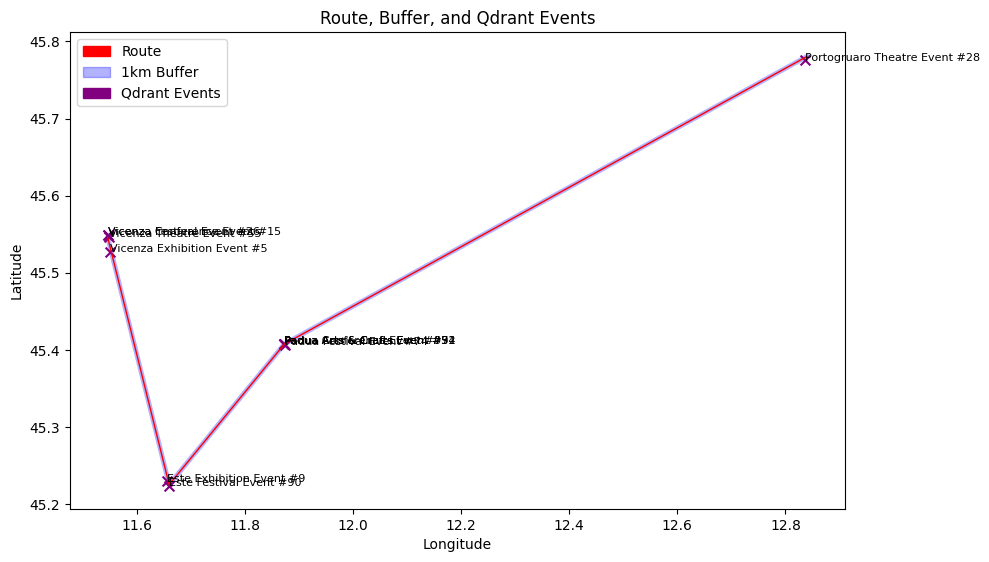

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.patches as mpatches

# Collect Qdrant results into a GeoDataFrame
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (no label here)
gpd.GeoSeries([route_line], crs="EPSG:4326").plot(ax=ax, color='red', linewidth=1)

# Plot the buffer (no label here)
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3)

# Plot Qdrant events
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50)
    # Optionally, add event titles
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

# Manually create legend patches
route_patch = mpatches.Patch(color='red', label='Route')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='1km Buffer')
events_patch = mpatches.Patch(color='purple', label='Qdrant Events')
ax.legend(handles=[route_patch, buffer_patch, events_patch])

ax.set_title("Route, Buffer, and Qdrant Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## I want to use Openstreetmap to create a real route

In [ ]:
%pip install osmnx

MultiDiGraph with 9945 nodes and 21417 edges
stampato G
325074361 9416572746
[325074361, 5001672068, 10819852393, 12559101771, 618643804, 618643777, 330196737, 330196268, 247911074, 1459121943, 330195233, 247906863, 330198013, 194420355, 254931559, 254931563, 254931550, 1544008135, 254931535, 254931536, 10315488615, 254931539, 254931542, 254931518, 517735773, 518014388, 517735726, 517735874, 517735554, 6697056271, 485924926, 243517142, 2310870131, 243517135, 256071918, 1834754045, 207094142, 7049685181, 255896874, 256071993, 256072058, 256072265, 762596339, 1132461607, 207093931, 521993247, 249442832, 249442864, 207096137, 210472874, 207094123, 12032040918, 465624031, 482256329, 482256334, 482256321, 729308457, 207096139, 2517681265, 263675896, 263675895, 729308463, 689585569, 729308491, 11252603899, 729308444, 729308551, 729308415, 729308494, 762106941, 677697786, 471611082, 729308468, 729308516, 729308545, 761251612, 687518445, 687518477, 260772863, 419383882, 415488489, 3936675385, 

<Axes: >

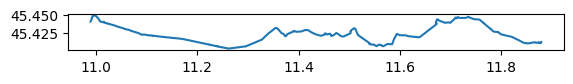

In [16]:
import osmnx as ox
from shapely.geometry import Polygon, LineString
import geopandas as gpd
import geopandas as gpd
import numpy as np
ox.settings.use_cache = True  # enable caching of HTTP requests

# Your origin and destination points (lat, lon) like (y,x)
#origin_point = (45.640317186277066, 12.241487413188237) # strada Terraglio TV
#destination_point = (45.68758465370057, 12.2562502911396) # prima di Selvana TV


origin_point = (45.41026004774276, 11.877749172855356) # Padova
destination_point = (45.44013878631641, 10.989916584327693) # Verona
#origin_point = (45.4109553303283, 11.883520063045811) # Padova (PD)
#destination_point = (45.55564536495325, 11.543093946961582) # Vicenza (VI)

#destination_point = (45.45795667928977, 10.982370142567046) # Verona (VR)
#origin_point = (45.5063774869007, 10.73446566988937) # Lazise (VR)
#destination_point =(45.43848433719987, 10.969985064989903) # Verona (VR)

# Create bounding box polygon covering both points
min_lat = min(origin_point[0], destination_point[0])
max_lat = max(origin_point[0], destination_point[0])
min_lon = min(origin_point[1], destination_point[1])
max_lon = max(origin_point[1], destination_point[1])

bbox_polygon = Polygon([
    (min_lon, min_lat),  # southwest
    (min_lon, max_lat),  # northwest
    (max_lon, max_lat),  # northeast
    (max_lon, min_lat),  # southeast
    (min_lon, min_lat)   # close polygon
])

from shapely.geometry import Polygon
bbox_polygon = bbox_polygon.buffer(0.01)  # buffer about 1 km depending on coordinates

# Download drivable road network within this polygon
G = ox.graph_from_polygon(bbox_polygon, network_type='drive', retain_all=True)
print(G)
print("stampato G")
# Find nearest nodes to origin and destination points in graph (lon, lat)
origin_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0],return_dist=False)
destination_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0],return_dist=False)
print(origin_node,destination_node)
#origin_node=247910834
#destination_node=530212898

# Compute shortest path by length
#route = ox.shortest_path(G, origin_node, destination_node, weight='length')
route = ox.shortest_path(G, origin_node, destination_node, weight='length')
print(route)


# import networkx as nx


# if nx.has_path(G, origin_node, destination_node):
#     print("Path ok tra origin:", origin_node ,"e destination:", destination_node)
# elif nx.has_path(G, destination_node, origin_node):
#         print("Path ok tra destination: ", destination_node ,"e origin:" , origin_node)
# else:
#     print("nessun path")# no path in either direction



# Extract node coordinates for route geometry
route_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]

# Create a LineString for the route
route_line = LineString(route_coords)

# Create GeoDataFrame for route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Convert to projected CRS for buffering
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_poly = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]

# Extract polygon coordinates for Qdrant filter
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

print(polygon_coords_qdrant)

# Plot the route
route_gdf.plot()


In [19]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

,id,title,type,category,description,city,start_date,end_date,url,location.venue,location.address,location.lat,location.lon
0,21,Padua Sport Event #21,Sport,Sport,Step into a world of wonder at this extraordin...,Padua,2025-08-29T01:03,2025-08-29T02:03,https://example.com/veneto-events/21,Palazzo Zabarella,"Palazzo Zabarella, Padua, Veneto",45.407717,11.873446
1,22,Verona Arts & Crafts Event #22,Arts & Crafts,Arts & Crafts,Expand your horizons with this insightful arts...,Verona,2025-08-29T22:45,2025-08-30T00:00,https://example.com/veneto-events/22,Museo Lapidario Maffeiano,"Museo Lapidario Maffeiano, Verona, Veneto",45.438180,10.991353
2,67,Padua Festival Event #67,Festival,Festival,Expand your horizons with this insightful fest...,Padua,2025-08-28T22:18,2025-08-29T05:18,https://example.com/veneto-events/67,Church of the Eremitani,"Church of the Eremitani, Padua, Veneto",45.407717,11.873446
3,68,Verona Festival Event #68,Festival,Festival,Explore the vibrant festival scene in Verona w...,Verona,2025-08-28T19:06,2025-08-28T22:06,https://example.com/veneto-events/68,Museum of Castelvecchio,"Museum of Castelvecchio, Verona, Veneto",45.438496,10.992412
4,79,Padua Arts & Crafts Event #79,Arts & Crafts,Arts & Crafts,Unwind and enjoy a delightful arts & crafts ex...,Padua,2025-08-28T19:52,2025-08-29T01:52,https://example.com/veneto-events/79,Palazzo della Ragione,"Palazzo della Ragione, Padua, Veneto",45.407717,11.873446
5,80,Padua Music Event #80,Music,Music,Expand your horizons with this insightful musi...,Padua,2025-08-29T09:54,2025-08-29T17:54,https://example.com/veneto-events/80,Palazzo Liviano,"Palazzo Liviano, Padua, Veneto",45.407986,11.871449
6,112,Verona Festival Event #112,Festival,Festival,Unwind and enjoy a delightful festival experie...,Verona,2025-08-25T15:49,2025-08-26T00:49,https://example.com/veneto-events/112,Piazza delle Erbe,"Piazza delle Erbe, Verona, Veneto",45.443062,10.997234
7,134,Verona Music Event #134,Music,Music,Step into a world of wonder at this extraordin...,Verona,2025-08-22T09:39,2025-08-22T14:39,https://example.com/veneto-events/134,Museo Lapidario Maffeiano,"Museo Lapidario Maffeiano, Verona, Veneto",45.438180,10.991353
8,137,Padua Food & Drink Event #137,Food & Drink,Food & Drink,Explore the vibrant food & drink scene in Padu...,Padua,2025-08-21T16:42,2025-08-21T23:42,https://example.com/veneto-events/137,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154
9,155,Verona Theatre Event #155,Theatre,Theatre,Dive into the world of theatre at this excitin...,Verona,2025-08-27T21:06,2025-08-28T02:06,https://example.com/veneto-events/155,Piazza dei Signori,"Piazza dei Signori, Verona, Veneto",45.443466,10.998079


/tmp/ipykernel_5237/1829689547.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


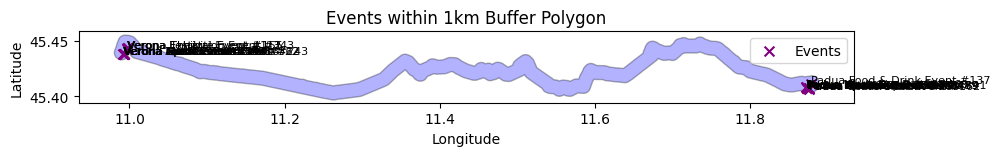

In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Build gdf_qdrant from Qdrant results if not already defined
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer polygon
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='1km Buffer')

# Plot the events inside the buffer
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events')
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

ax.set_title("Events within 1km Buffer Polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [1]:
!pip install openrouteservice

In [3]:
import openrouteservice
from openrouteservice import convert
import os

from dotenv import load_dotenv

load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")


# Specify your personal API key here
api_key = OPENROUTE_API_KEY

# Initialize the client with your API key
client = openrouteservice.Client(key=api_key)

# Define coordinates as a list of longitude, latitude tuples
coords = [(8.34234, 48.23424), (8.34423, 48.26424)]

# Request directions for cycling-regular profile
routes = client.directions(coords, profile='cycling-regular', optimize_waypoints=True)

# Print the raw response
print(routes)

# Decode the polyline geometry to GeoJSON format
geometry = routes['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)

# Print decoded geometry
print(decoded)


/home/biso/development/my_projects/.venv/lib/python3.12/site-packages/openrouteservice/directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


{'bbox': [8.327725, 48.233135, 8.345244, 48.263552], 'routes': [{'summary': {'distance': 5205.9, 'duration': 1305.3}, 'segments': [{'distance': 5205.9, 'duration': 1305.3, 'steps': [{'distance': 888.7, 'duration': 234.8, 'type': 11, 'instruction': 'Head southwest', 'name': '-', 'way_points': [0, 24]}, {'distance': 822.8, 'duration': 164.6, 'type': 5, 'instruction': 'Turn slight right onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [24, 52]}, {'distance': 263.7, 'duration': 59.3, 'type': 1, 'instruction': 'Turn right', 'name': '-', 'way_points': [52, 61]}, {'distance': 301.9, 'duration': 67.9, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [61, 73]}, {'distance': 535.6, 'duration': 118.0, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [73, 84]}, {'distance': 248.1, 'duration': 55.8, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [84, 92]}, {'distance': 286.6, 'duration': 73.7, 'type': 1, 'inst

In [1]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [folium]2m2/3 [folium]


[{'lon': 10.96556088466177, 'lat': 45.40482856485638}, {'lon': 10.965812836202321, 'lat': 45.40528130397753}, {'lon': 10.966167105728772, 'lat': 45.4058371205697}, {'lon': 10.966596070017836, 'lat': 45.40636635498467}, {'lon': 10.967095730341379, 'lat': 45.40686407460796}, {'lon': 10.967661428955527, 'lat': 45.40732564067798}, {'lon': 10.968287892519294, 'lat': 45.40774675149463}, {'lon': 10.968969281251756, 'lat': 45.408123482484086}, {'lon': 10.969699243369407, 'lat': 45.408452322747834}, {'lon': 10.970470974296372, 'lat': 45.40873020775643}, {'lon': 10.971277280095423, 'lat': 45.408954547884406}, {'lon': 10.972110644528575, 'lat': 45.409123252521795}, {'lon': 10.972556088330087, 'lat': 45.40918150081909}, {'lon': 10.972570751562545, 'lat': 45.40933992516408}, {'lon': 10.972577819838191, 'lat': 45.40941021997824}, {'lon': 10.972602634967158, 'lat': 45.409638818167245}, {'lon': 10.972279635183204, 'lat': 45.40995886333495}, {'lon': 10.971825547240854, 'lat': 45.41052416788372}, {'lon'

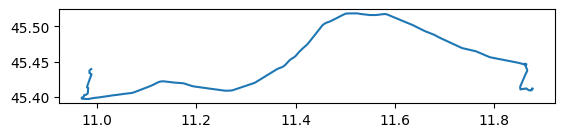

In [1]:
import openrouteservice
from shapely.geometry import LineString, Polygon
import geopandas as gpd
import numpy as np
import folium
import os

from dotenv import load_dotenv

load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")


# Specify your personal API key here
api_key = OPENROUTE_API_KEY

# Initialize the client with your API key
client = openrouteservice.Client(key=api_key)

# Define origin and destination points as (lon, lat)
#origin_point = (12.241487413188237, 45.640317186277066)  # Strada Terraglio TV (lon, lat)
#destination_point = (12.2562502911396, 45.68758465370057)  # Prima di Selvana TV (lon, lat)


origin_point = (11.877749172855356, 45.41026004774276) # Padova
destination_point = (10.989916584327693, 45.44013878631641) # Verona
# Request directions from ORS (driving-car profile)
coords = [origin_point, destination_point]
#routes = client.directions(coordinates=coords, profile='driving-car', format='geojson')


radiuses = [1000, 1000]  # Snap within 1km radius for each point

routes = client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')


# Extract route geometry (LineString in GeoJSON format)
route_geometry = routes['features'][0]['geometry']


route_coords = route_geometry['coordinates']
# Convert GeoJSON LineString coordinates to shapely LineString
route_line = LineString(route_geometry['coordinates'])

# Create a GeoDataFrame for the route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Buffer the route by 1000 meters (1 km) in projected coordinates
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_polygon = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]

# Extract polygon coordinates for your Qdrant filter or other purposes
polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

print(polygon_coords_qdrant)

# Optionally plot the route
route_gdf.plot()

# This is the folium map part
# Visualize route and buffer polygon on a folium map
map_center = [(origin_point[1] + destination_point[1]) / 2, (origin_point[0] + destination_point[0]) / 2]
m = folium.Map(location=map_center, zoom_start=9)

# Add the route line (lat, lon format for folium)
folium.PolyLine(locations=[(lat, lon) for lon, lat in route_coords], color='blue', weight=5).add_to(m)

# Add the buffer polygon (GeoJSON format)
folium.GeoJson(buffer_polygon.__geo_interface__, style_function=lambda x: {'color': 'red', 'fillOpacity': 0.1}).add_to(m)
# Save the map to an HTML file to view
#m.save('route_map.html')

# To print the map
m

In [2]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.96556088466177, 'lat': 45.40482856485638}, {'lon': 10.965812836202321, 'lat': 45.40528130397753}, {'lon': 10.966167105728772, 'lat': 45.4058371205697}, {'lon': 10.966596070017836, 'lat': 45.40636635498467}, {'lon': 10.967095730341379, 'lat': 45.40686407460796}, {'lon': 10.967661428955527, 'lat': 45.40732564067798}, {'lon': 10.968287892519294, 'lat': 45.40774675149463}, {'lon': 10.968969281251756, 'lat': 45.408123482484086}, {'lon': 10.969699243369407, 'lat': 45.408452322747834}, {'lon': 10.970470974296372, 'lat': 45.40873020775643}, {'lon': 10.971277280095423, 'lat': 45.408954547884406}, {'lon': 10.972110644528575, 'lat': 45.409123252521795}, {'lon': 10.972556088330087, 'lat': 45.40918150081909}, {'lon': 10.972570751562545, 'lat': 45.40933992516408}, {'lon': 10.972577819838191, 'lat': 45.40941021997824}, {'lon': 10.972602634967158, 'lat': 45.409638818167245}, {'lon': 10.972279635183204, 'lat': 45.40995886333495}, {'lon': 10.971825547240854, 'lat': 45.41052416788372}, {'lon'

,id,title,type,category,description,city,start_date,end_date,url,location.venue,location.address,location.lat,location.lon
0,21,Padua Sport Event #21,Sport,Sport,Step into a world of wonder at this extraordin...,Padua,2025-08-29T01:03,2025-08-29T02:03,https://example.com/veneto-events/21,Palazzo Zabarella,"Palazzo Zabarella, Padua, Veneto",45.407717,11.873446
1,22,Verona Arts & Crafts Event #22,Arts & Crafts,Arts & Crafts,Expand your horizons with this insightful arts...,Verona,2025-08-29T22:45,2025-08-30T00:00,https://example.com/veneto-events/22,Museo Lapidario Maffeiano,"Museo Lapidario Maffeiano, Verona, Veneto",45.438180,10.991353
2,67,Padua Festival Event #67,Festival,Festival,Expand your horizons with this insightful fest...,Padua,2025-08-28T22:18,2025-08-29T05:18,https://example.com/veneto-events/67,Church of the Eremitani,"Church of the Eremitani, Padua, Veneto",45.407717,11.873446
3,68,Verona Festival Event #68,Festival,Festival,Explore the vibrant festival scene in Verona w...,Verona,2025-08-28T19:06,2025-08-28T22:06,https://example.com/veneto-events/68,Museum of Castelvecchio,"Museum of Castelvecchio, Verona, Veneto",45.438496,10.992412
4,79,Padua Arts & Crafts Event #79,Arts & Crafts,Arts & Crafts,Unwind and enjoy a delightful arts & crafts ex...,Padua,2025-08-28T19:52,2025-08-29T01:52,https://example.com/veneto-events/79,Palazzo della Ragione,"Palazzo della Ragione, Padua, Veneto",45.407717,11.873446
5,80,Padua Music Event #80,Music,Music,Expand your horizons with this insightful musi...,Padua,2025-08-29T09:54,2025-08-29T17:54,https://example.com/veneto-events/80,Palazzo Liviano,"Palazzo Liviano, Padua, Veneto",45.407986,11.871449
6,112,Verona Festival Event #112,Festival,Festival,Unwind and enjoy a delightful festival experie...,Verona,2025-08-25T15:49,2025-08-26T00:49,https://example.com/veneto-events/112,Piazza delle Erbe,"Piazza delle Erbe, Verona, Veneto",45.443062,10.997234
7,134,Verona Music Event #134,Music,Music,Step into a world of wonder at this extraordin...,Verona,2025-08-22T09:39,2025-08-22T14:39,https://example.com/veneto-events/134,Museo Lapidario Maffeiano,"Museo Lapidario Maffeiano, Verona, Veneto",45.438180,10.991353
8,137,Padua Food & Drink Event #137,Food & Drink,Food & Drink,Explore the vibrant food & drink scene in Padu...,Padua,2025-08-21T16:42,2025-08-21T23:42,https://example.com/veneto-events/137,Museo Bottacin,"Museo Bottacin, Padua, Veneto",45.411432,11.878154
9,162,Padua Conference Event #162,Conference,Conference,Connect with fellow enthusiasts at this lively...,Padua,2025-08-21T23:31,2025-08-22T07:31,https://example.com/veneto-events/162,Museo della Padova Ebraica,"Museo della Padova Ebraica, Padua, Veneto",45.406043,11.875922


/tmp/ipykernel_5237/1829689547.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


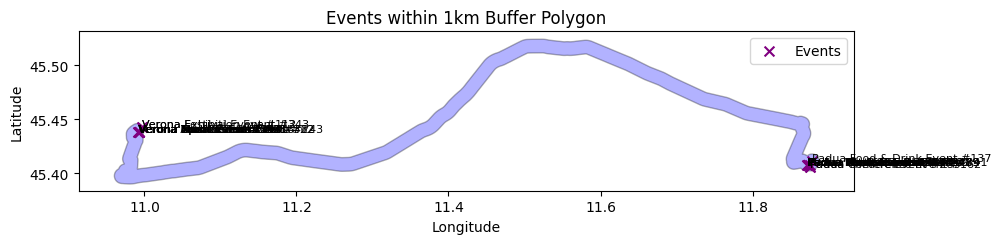

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Build gdf_qdrant from Qdrant results if not already defined
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer polygon
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='1km Buffer')

# Plot the events inside the buffer
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events')
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

ax.set_title("Events within 1km Buffer Polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

## The complete code

Event list on the route
     id                           title           type       category  \
0    21           Padua Sport Event #21          Sport          Sport   
1    22  Verona Arts & Crafts Event #22  Arts & Crafts  Arts & Crafts   
2    67        Padua Festival Event #67       Festival       Festival   
3    68       Verona Festival Event #68       Festival       Festival   
4    79   Padua Arts & Crafts Event #79  Arts & Crafts  Arts & Crafts   
5    80           Padua Music Event #80          Music          Music   
6   112      Verona Festival Event #112       Festival       Festival   
7   134         Verona Music Event #134          Music          Music   
8   137   Padua Food & Drink Event #137   Food & Drink   Food & Drink   
9   162     Padua Conference Event #162     Conference     Conference   
10  184          Verona Tour Event #184           Tour           Tour   
11  198         Verona Sport Event #198          Sport          Sport   
12  207       Padua Worksho

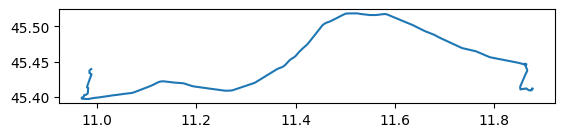

In [21]:
import openrouteservice
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np
import folium
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import pandas as pd

# Load environment variables
load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

# Get API keys and URLs from environment variables
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Initialize OpenRouteService client
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

# Define origin and destination points (lon, lat)
origin_point = (11.877749172855356, 45.41026004774276)  # Padova
destination_point = (10.989916584327693, 45.44013878631641)  # Verona

# Request directions from ORS (driving-car profile)
coords = [origin_point, destination_point]
radiuses = [1000, 1000]  # Snap within 1km radius for each point
routes = ors_client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')

# Extract route geometry (LineString in GeoJSON format)
route_geometry = routes['features'][0]['geometry']
route_coords = route_geometry['coordinates']

# Convert GeoJSON LineString coordinates to shapely LineString
route_line = LineString(route_coords)

# Create GeoDataFrame for the route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Buffer the route by 1000 meters (1 km) in projected coordinates
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_polygon = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]




# Extract polygon coordinates for Qdrant geo filter (list of {"lon":, "lat":})
polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

#print(polygon_coords_qdrant)

# Optionally plot the route
route_gdf.plot()

# Initialize Qdrant client
qdrant_client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# Build geo filter for Qdrant using GeoLineString wrapper for exterior polygon
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # Replace with your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# Query Qdrant points inside buffer polygon
results = qdrant_client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,
    with_payload=True
)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame from payloads
df = pd.json_normalize(payloads)

# Create folium map centered between origin and destination
map_center = [(origin_point[1] + destination_point[1]) / 2, (origin_point[0] + destination_point[0]) / 2]
#m = folium.Map(location=map_center, zoom_start=9)
m = folium.Map(location=map_center, zoom_start=9, zoom_control=False, scrollWheelZoom=False, dragging=False)


# Add route line to the map (convert (lon, lat) to (lat, lon))
folium.PolyLine(locations=[(lat, lon) for lon, lat in route_coords], color='blue', weight=5).add_to(m)

# Add buffer polygon to the map
folium.GeoJson(buffer_polygon.__geo_interface__, style_function=lambda x: {'color': 'red', 'fillOpacity': 0.1}).add_to(m)

# Show the map (in Jupyter use just 'm' as last statement or display(m))
#m  # Use in Jupyter to display map
# Add starting point marker
folium.Marker(
    location=[origin_point[1], origin_point[0]],  # lat, lon
    icon=folium.DivIcon(
        html='<div style="font-size: 16pt; color: #006400; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5);">🚦 Start</div>'
    )
).add_to(m)

# Add arrival point marker
folium.Marker(
    location=[destination_point[1], destination_point[0]],  # lat, lon
    icon=folium.DivIcon(
        html='<div style="font-size: 16pt; color: #B22222; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5);">🏁 End</div>'
    )
).add_to(m)



from IPython.display import display

#print("Buffer polygon coordinates for Qdrant filter:")
#print(polygon_coords_qdrant)

print("Event list on the route")
print(df)
display(m)  # Explicitly display the folium map in the same cell


In [16]:
import openrouteservice
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np
import folium
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import pandas as pd

# Load environment variables
load_dotenv(dotenv_path="/home/biso/development/my_projects/event_map/superlinked_app/.env")

# Get API keys and URLs from environment variables
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Initialize OpenRouteService client
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

# Define origin and destination points (lon, lat)
origin_point = (11.877749172855356, 45.41026004774276)  # Padova
destination_point = (10.989916584327693, 45.44013878631641)  # Verona

# Request directions from ORS (driving-car profile)
coords = [origin_point, destination_point]
radiuses = [1000, 1000]  # Snap within 1km radius for each point
routes = ors_client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')

# Extract route geometry (LineString in GeoJSON format)
route_geometry = routes['features'][0]['geometry']
route_coords = route_geometry['coordinates']

# Convert GeoJSON LineString coordinates to shapely LineString
route_line = LineString(route_coords)

# Create GeoDataFrame for the route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Buffer the route by 1000 meters (1 km) in projected coordinates
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_polygon = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]




# Extract polygon coordinates for Qdrant geo filter (list of {"lon":, "lat":})
polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

#print(polygon_coords_qdrant)

# Optionally plot the route
#route_gdf.plot()

# Initialize Qdrant client
qdrant_client = QdrantClient(
    url=QDRANT_URL,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# Build geo filter for Qdrant using GeoLineString wrapper for exterior polygon
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # Replace with your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# Query Qdrant points inside buffer polygon
results = qdrant_client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,
    with_payload=True
)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame from payloads
df = pd.json_normalize(payloads)

# Create folium map centered between origin and destination
map_center = [(origin_point[1] + destination_point[1]) / 2, (origin_point[0] + destination_point[0]) / 2]
#m = folium.Map(location=map_center, zoom_start=9)
m = folium.Map(location=map_center, zoom_start=9, zoom_control=False, scrollWheelZoom=False, dragging=False)
m = folium.Map(
    location=map_center,
    zoom_start=9,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    height=450  # set height explicitly here
)


# Add route line to the map (convert (lon, lat) to (lat, lon))
folium.PolyLine(locations=[(lat, lon) for lon, lat in route_coords], color='blue', weight=5).add_to(m)

# Add buffer polygon to the map
folium.GeoJson(buffer_polygon.__geo_interface__, style_function=lambda x: {'color': 'red', 'fillOpacity': 0.1}).add_to(m)

# Show the map (in Jupyter use just 'm' as last statement or display(m))
#m  # Use in Jupyter to display map
# Add starting point marker
folium.Marker(
    location=[origin_point[1], origin_point[0]],  # lat, lon
    icon=folium.DivIcon(
        html='<div style="font-size: 16pt; color: #006400; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5);">🚦 Start</div>'
    )
).add_to(m)

# Add arrival point marker
folium.Marker(
    location=[destination_point[1], destination_point[0]],  # lat, lon
    icon=folium.DivIcon(
        html='<div style="font-size: 16pt; color: #B22222; font-weight: bold; text-shadow: 1px 1px 1px rgba(0,0,0,0.5);">🏁 End</div>'
    )
).add_to(m)

from IPython.display import display, HTML

# Generate the map HTML as an iframe
map_html = m._repr_html_()

# Create a scrollable list of events as HTML
event_list_html = """
<div style="width: 400px; height: 400px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;">
  <h3>Event List on the route</h3>
  <ul style="list-style-type: none; padding-left: 0;">
"""

# Iterate over the DataFrame rows to create list items
for _, row in df.iterrows():
    # Customize what you want to show from each event payload. Example assuming 'name' and 'description'
    title = row.get('title', 'No Name')
    description = row.get('description', '')
    address = row.get('location.address', '')
    event_list_html += f"<li style='margin-bottom: 10px;'><strong>{title}</strong><br>{description}</br><br>{address}</br></br></li>"

event_list_html += "</ul></div>"

# Combine map and list side-by-side with flexbox
combined_html = f"""
<div style="display: flex; gap: 20px; align-items: flex-start;">
  <div style="flex: 1; min-width: 600px;">{map_html}</div>
  <div>{event_list_html}</div>
</div>
"""



# Display combined in Jupyter output cell
display(HTML(combined_html))
